In [1]:
%run ../cube/Cube.ipynb

Support algs imported!
Cube initiated


In [2]:
import json

In [4]:
@njit
def _inc_special(ids):
    for i in range(len(ids)):
        ids[i]+=1
        ids[i]%=9 # change based on number of moves
        if ids[i]:
            break
    return ids

@njit
def _is_valid_special(length,ids):
    for i in range(length-1):
        if ids[i]//3==ids[i+1]//3:
            return False
        if ids[i]//6==ids[i+1]//6 and (ids[i]//3)%2:
            return False
    return True      

@njit
def _increment_special(length,ids):
    ids = _inc_special(ids)
    while not _is_valid_special(length,ids):
        ids = _inc_special(ids)
    return ids

length = 4
ids = np.array([0,3,6,0])
_increment_special(length,ids)


array([1, 3, 6, 0])

In [8]:
class alg_index_special:
    def __init__(self, length):
        '''
        length: int
        '''
        self.length = length
        self.moves = ["D","D'","D2","U","U'","U2","R","R'","R2"] # change to whatever you want to gen
        self.ids = np.array(([0,3,6]*int(length/3+1))[:length]) # change based on type of algs you gen
    
    def is_valid(self):
        return _is_valid_special(self.length,self.ids)
    
    def inc(self):
        ids = _inc_special(ids)
    
    def increment(self):
        self.ids = _increment_special(self.length,self.ids)
    
    def get_alg(self):
        scr = self.moves[self.ids[0]]
        for i in range(1,len(self.ids)):
            scr += f" {self.moves[self.ids[i]]}"
        return scr

In [348]:
def check_if_valid_alg(alg):
    '''
    check if valid alg
    how: make "alg index" of the alg and check _is_valid
    '''
    valid_moves = ["R","R'","R2","L","L'","L2","U","U'","U2","D","D'","D2","F","F'","F2","B","B'","B2"]
    moves = alg.split(" ")
    length = len(moves)
    ai = []

    for move in moves:
        if move[0] == "r":
            move = "L"
        ai.append(valid_moves.index(move))

    return _is_valid(length,np.array(ai))


def gen_extra_algs(algs, insert_move, t = 0, print_time = True):
    # note: this can gen R L and L R, should force only one order

    extra_algs = []
    k = 0
    for a, alg in enumerate(algs):
        moves = alg.split(" ")[:-1] # we don't want the last move, since we're inserting a move after it

        if 100*a//len(algs)>k:
            k += 1
            print(f"{k}% done in {time.time()-t}")

        for i in range(len(moves)+1):
            new_alg = ""
            for j in range(len(moves)+1):
                # make alg again, but insert insert_move between place j-1 and j
                if i == j < len(moves):
                    new_alg += insert_move + " " + moves[j] + " "
                elif j < len(moves):
                    new_alg += moves[j] + " "
                elif i == j: # j == len(moves) and i == j means we add insert_move to the end
                    new_alg += insert_move

            app_alg = new_alg.strip()
            if check_if_valid_alg(app_alg) and app_alg not in extra_algs:
                extra_algs.append(app_alg)
    return extra_algs

def gen_algs(n, insert_move = False, insert_move_inv = True, print_time = True):

    algs = []

    t = time.time()

    for i in range(n):
        ai = alg_index_special(i+1)
        start_alg = ai.get_alg()

        algs.append(start_alg)
        ai.increment()

        while start_alg != ai.get_alg():
            algs.append(ai.get_alg())
            ai.increment()

        if print_time:
            print(f"Algs of length {i+1} genned after {round(time.time()-t,3)}s")
        
    # if insert_move is set to a move
    if insert_move:
        if print_time:
            print(f"Inserting extra move")
        extra_algs = gen_extra_algs(algs, insert_move, t, print_time)
        if insert_move_inv:
            if print_time:
                print(f"Extra move inserted after {round(time.time()-t,3)}s. Inserting inverse of extra move.")
            extra_algs += gen_extra_algs(algs, inverse_alg(insert_move), t, print_time)
            print(f"Extra inverse move added after {round(time.time()-t,3)}s")

        algs += extra_algs

    return algs

algs = gen_algs(7, "r", insert_move_inv = True)
print(len(algs))

Algs of length 1 genned after 0.0s
Algs of length 2 genned after 0.001s
Algs of length 3 genned after 0.002s
Algs of length 4 genned after 0.005s
Algs of length 5 genned after 0.024s
Algs of length 6 genned after 0.126s
Algs of length 7 genned after 0.728s
Inserting extra move
1% done in 0.7644762992858887
2% done in 0.83567214012146
3% done in 0.9021322727203369
4% done in 0.9734053611755371
5% done in 1.096104383468628
6% done in 1.4761621952056885
7% done in 1.715637445449829
8% done in 1.998358964920044
9% done in 2.2872540950775146
10% done in 2.563168525695801
11% done in 2.954289674758911
12% done in 3.3907196521759033
13% done in 3.763137102127075
14% done in 4.135850429534912
15% done in 4.511592864990234
16% done in 4.949511766433716
17% done in 5.412148475646973
18% done in 5.83384895324707
19% done in 6.270725965499878
20% done in 6.685478210449219
21% done in 7.132206916809082
22% done in 7.767515659332275
23% done in 8.619074821472168
24% done in 9.576099872589111
25% don

In [349]:
def gen_table(algs):
    '''
    Gen dictionary with keys being cases reached by inverting each alg, with dict[case] = alg
    '''
    table = {}

    for alg in algs:

        inv = inverse_alg(alg)
        # skip algs ending with U* as the first move is equivalent to a AUF
        if inv[0]=="U":
            continue

        cube = Cube(2) # only F2L
        cube.apply_moves(alg)
        case = id_from_state(cube.state)

        if case not in table.keys():
            table[case] = [inv]
        else:
            table[case] += [inv]

    return table

table = gen_table(algs)

In [350]:
def gen_LL_algs(algs, table, print_time = True):
    '''
    gens LL algs using algs as premoves and the table to finish the algs
    '''
    LL_algs = []

    j = 0
    t = time.time()
    for i, premove in enumerate(algs):
        if premove[0] == "U":
            continue

        if 100*i//len(algs)>j:
            j += 1
            print(f"{j}% done in {time.time()-t}")

        cube = Cube(2)
        cube.apply_moves(premove)

        case = id_from_state(cube.state)
        if case in table:
            for finish in table[case]:
                new_alg = cancel_alg(premove + " " + finish)

                # append alg if it's not empty ("") and it doesn't exist already (duplicates from cancling moves for example)
                if new_alg and new_alg not in LL_algs: 
                    LL_algs.append(new_alg)
    
    return LL_algs

LL_algs = gen_LL_algs(algs, table)
len(LL_algs)

1% done in 0.07416200637817383
2% done in 0.20653605461120605
3% done in 0.34585118293762207
4% done in 0.508007287979126
5% done in 0.6809966564178467
6% done in 0.9143452644348145
7% done in 1.0830252170562744
8% done in 1.1501224040985107
9% done in 1.2185721397399902
10% done in 1.266756296157837
11% done in 1.3752996921539307
12% done in 1.4710028171539307
13% done in 1.5664877891540527
14% done in 1.6484832763671875
15% done in 1.7302570343017578
16% done in 1.8124184608459473
17% done in 1.8917112350463867
18% done in 1.9732427597045898
19% done in 2.0550711154937744
20% done in 2.14025616645813
21% done in 2.203017473220825
22% done in 2.2553293704986572
23% done in 2.3015618324279785
24% done in 2.3442444801330566
25% done in 2.4008755683898926
26% done in 2.4878339767456055
27% done in 2.5702075958251953
28% done in 2.631620407104492
29% done in 2.6970388889312744
30% done in 2.7857675552368164
31% done in 2.872958183288574
32% done in 2.936631202697754
33% done in 2.97900223

22114

In [351]:
def score_alg(alg):
    return len(alg.split(" "))*2 + alg.count("R2")*0.5

def sort_algs(algs):
    '''
    sort into dictionary based on which case the alg solves
    '''
    LL_algs_dict = {}
    for alg in algs:
        ID = 0
        for u1 in ["", "U ", "U2 ", "U' "]:
            for u2 in ["", " U", " U2", " U'"]:
                u_alg_u = u1+alg+u2
                cube = Cube()
                cube.apply_moves(u_alg_u)

                case = id_from_state(cube.state)
                if case in LL_algs_dict:
                    ID = case
        if ID:
            LL_algs_dict[ID] += [alg]
        else:
            cube = Cube()
            cube.apply_moves(alg)
            ID = id_from_state(cube.state)
            LL_algs_dict[ID] = [alg]

    # sort the lists in the dict according to length of algs
    sorted_dict = {key: sorted(value, key=score_alg) for key, value in LL_algs_dict.items()}
    
    return sorted_dict

LL_algs_dict = sort_algs(LL_algs)
len(LL_algs_dict)

419

In [352]:
def score_key(key):
    return score_alg(LL_algs_dict[key][0])

LL_keys = list(LL_algs_dict.keys())
sorted_LL_keys = sorted(LL_algs_dict, key = score_key)

In [353]:
def zblls_only(LL_algs_dict):
    '''
    remove all algs that are not zblls
    '''
    new_dict = {}
    for key, algs in LL_algs_dict.items():
        cube = Cube()
        cube.apply_moves(algs[0])
        case_edges = id_from_state(cube.state,np.array([37,39,40,41,43]))

        if case_edges == "55555":
            new_dict[key] = algs
    return new_dict


zblls = zblls_only(LL_algs_dict)
print(len(zblls))
zbll_keys = list(zblls.keys())
sorted_zblls_keys = sorted(zblls, key = score_key)

200


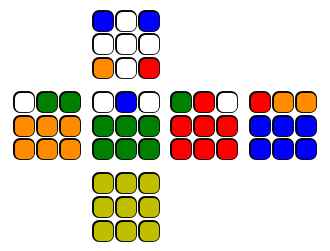

108
1. R' U2 R U R' U R2 U R' U R U2 R'
2. R U R' U R U2 R2 U2 R U R' U R


In [294]:
# i = -1
# i -=2
i += 1


key = sorted_LL_keys[i]
algs_LL = LL_algs_dict[key]
cube = Cube()
cube.apply_moves(inverse_alg(algs_LL[0]))
cube.plot()

print(i)
for j, alg in enumerate(algs_LL):
    print(f"{j+1}. {alg}")

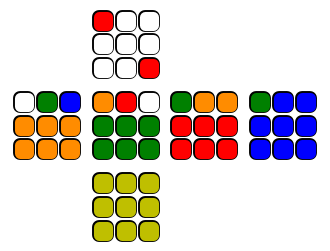

187
1. R U2 R2 D' r U2 R r' U R' D R2 U' R' (14)


In [461]:
# i = -1
# i -=2 # -1 overall
i += 1


key = sorted_zblls_keys[i]
algs_LL = zblls[key]
cube = Cube()
cube.apply_moves(inverse_alg(algs_LL[0]))
cube.plot()

print(i)
for j, alg in enumerate(algs_LL):
    print(f"{j+1}. {alg} ({len(alg.split(' '))})")

In [462]:
# # dump the zbll algs in a json file
# with open('zblls_RUD_r_14.json', 'w') as fp:
#     json.dump(zblls, fp)